In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.visualization import hist

In [2]:
import scienceplots

plt.style.use(['science', 'ieee'])

In [3]:
results_path = Path("../data/results")
dfs = []

for result_path in results_path.iterdir():
    if str(result_path).endswith(".parquet"):
        dfs.append(pd.read_parquet(result_path))

df = pd.concat(dfs)

In [37]:
cm_df = pd.read_parquet("../data/results/confusion_matrix_metrics.parquet")

In [38]:
cm_df.columns = ["Experimento", "Acurácia", "Sensibilidade", "Precisão", "Curva PR"]

Artefatos para discussão dos resultados dos experimentos
- Tabela com medidas de acurácia, sensibilidade, precisão, f1
- Distribuiçãos das medidas da matriz de confusão
- Curvas de convergência dos diferentes cenários
- Testes de hipótese para avaliar se modelos treinados com dados sintéticos tem performance diferente de modelos treinados com dados reais


In [39]:
# cm_df = cm_df[cm_df.accuracy > 0.7].copy()

In [40]:
cm_df.groupby("Experimento")["Experimento"].count()

Experimento
XRAY-64x64-REAL                    63
XRAY-64x64-SYNTHETIC-BALANCED      35
XRAY-64x64-SYNTHETIC-UNBALANCED    32
Name: Experimento, dtype: int64

## Medidas da matriz de confusão

In [41]:
cm_df["F1"] = (
    2
    * (cm_df["Precisão"] * cm_df["Precisão"])
    / (cm_df["Precisão"] + cm_df["Precisão"])
)

In [43]:
(
    cm_df
    .groupby("Experimento")
    .agg(
        mean_accuracy=("Acurácia", "mean"),
        mean_precision=("Precisão", "mean"),
        mean_recall=("Sensibilidade", "mean"),
        mean_f1=("F1", "mean"),
        std_accuracy=("Acurácia", "std"),
        std_precision=("Precisão", "std"),
        std_recall=("Sensibilidade", "std"),
        std_f1=("F1", "std"),
    )
)

,mean_accuracy,mean_precision,mean_recall,mean_f1,std_accuracy,std_precision,std_recall,std_f1
Experimento,,,,,,,,
XRAY-64x64-REAL,0.737052,0.716552,0.970859,0.716552,0.055971,0.046193,0.015524,0.046193
XRAY-64x64-SYNTHETIC-BALANCED,0.793178,0.823687,0.857143,0.823687,0.015440,0.037467,0.041127,0.037467
XRAY-64x64-SYNTHETIC-UNBALANCED,0.764974,0.762920,0.920433,0.762920,0.054637,0.054714,0.033193,0.054714


## Distribuição das medidas

In [9]:
from astropy.stats import sigma_clip

In [46]:
experiments = cm_df["Experimento"].unique()
metrics = ["Acurácia", "Precisão", "Sensibilidade", "F1"]

In [100]:
exp_colors = {
    "XRAY-64x64-REAL": "#000",
    "XRAY-64x64-SYNTHETIC-BALANCED": "#E01449",
    "XRAY-64x64-SYNTHETIC-UNBALANCED": "#2AB3E1",
}

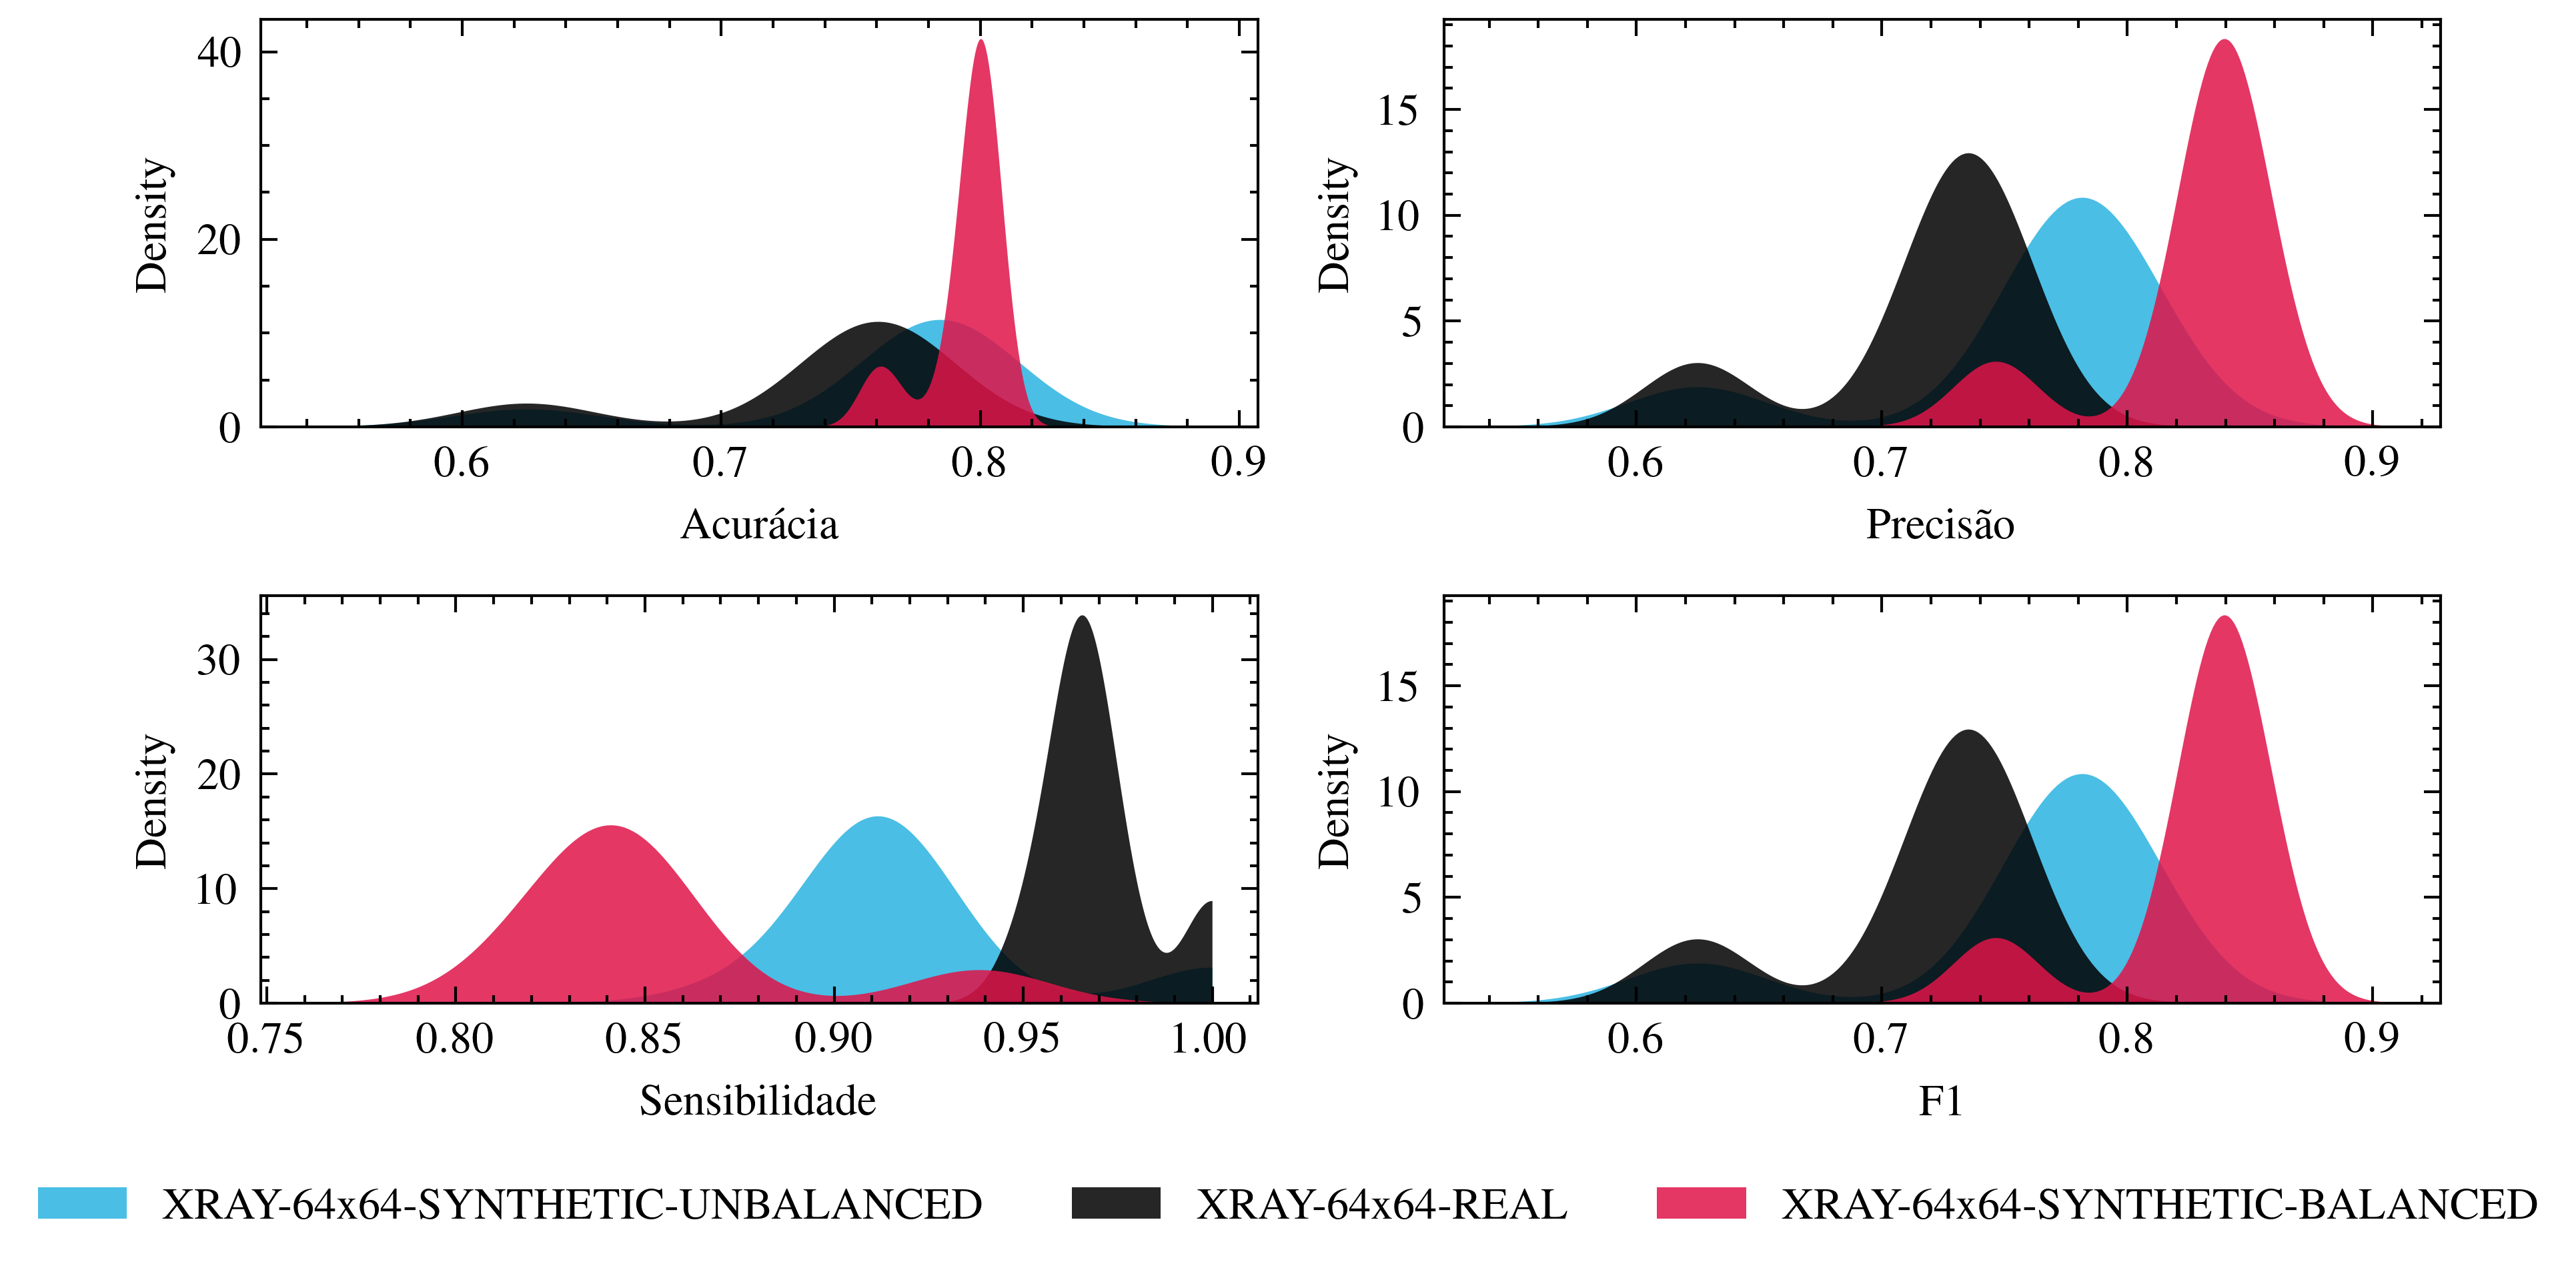

In [132]:
fig, axes = plt.subplots(2, 2, figsize=(6, 3))

i = 0

for idx, metric in enumerate(metrics):
    
    if idx == 2:
        i += 1
    
    j = idx % 2
    
    for exp in experiments:
        
        data = cm_df[cm_df["Experimento"] == exp][metric].sample(n=30, replace=False, random_state=1)
        
        sns.kdeplot(data, label=exp, ax=axes[i, j], fill=True, alpha=.85, edgecolor=None, clip=(0, 1), bw_adjust=1, color=exp_colors.get(exp))
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="lower center", ncol=3, bbox_to_anchor=(0.5,-0.08))
fig.tight_layout()
plt.savefig("experimento-metricas-densidade.pdf")

In [102]:
from scipy.stats import ttest_ind, mannwhitneyu, normaltest

In [104]:
for metric in metrics:
    real = cm_df[cm_df.Experimento=="XRAY-64x64-REAL"][metric]
    synth = cm_df[cm_df.Experimento=="XRAY-64x64-SYNTHETIC-UNBALANCED"][metric]
    
    print('real normal', normaltest(real).pvalue)
    print('synth normal', normaltest(synth).pvalue)
    
    print(metric, mannwhitneyu(real, synth).pvalue)
    
    print()

real normal 0.0002127715971705477
synth normal 5.249035632182432e-06
Acurácia 4.14570045925083e-07

real normal 0.0004186839183935134
synth normal 1.5645982635032242e-05
Precisão 1.378137785750437e-09

real normal 0.010018300489876347
synth normal 0.0003790361580356817
Sensibilidade 6.994626422591712e-10

real normal 0.00041868391839351254
synth normal 1.5645982635032337e-05
F1 1.378137785750437e-09



In [106]:
for metric in metrics:
    real = cm_df[cm_df.Experimento=="XRAY-64x64-REAL"][metric]
    synth = cm_df[cm_df.Experimento=="XRAY-64x64-SYNTHETIC-BALANCED"][metric]
    
    print('real normal', normaltest(real).pvalue)
    print('synth normal', normaltest(synth).pvalue)
    print(metric, mannwhitneyu(real, synth).pvalue)
    print()

real normal 0.0002127715971705477
synth normal 0.0013141248085139605
Acurácia 4.0692376949922e-12

real normal 0.0004186839183935134
synth normal 0.0006488251289033274
Precisão 1.261795054066153e-13

real normal 0.010018300489876347
synth normal 0.0020572481650257793
Sensibilidade 4.12093258783334e-16

real normal 0.00041868391839351254
synth normal 0.0006488251289033166
F1 1.261795054066153e-13



## Curva precision recall

Para os experimentos com as melhores medidas f1

In [113]:
base_selection_metric = "F1"

_df = cm_df.groupby("Experimento").agg({base_selection_metric: "max"}).reset_index()

selected_exp_df = cm_df.merge(_df, on=["Experimento", base_selection_metric], how="inner").sort_values(by="F1")

In [114]:
selected_exp_df

,Experimento,Acurácia,Sensibilidade,Precisão,Curva PR,F1
2,XRAY-64x64-REAL,0.785256,0.946154,0.765560,"[[0.625, 0.6260032102728732, 0.627009646302250...",0.765560
1,XRAY-64x64-SYNTHETIC-UNBALANCED,0.788462,0.869231,0.807143,"[[0.625, 0.6260032102728732, 0.627009646302250...",0.807143
0,XRAY-64x64-SYNTHETIC-BALANCED,0.806090,0.825641,0.858667,"[[0.625, 0.6260032102728732, 0.627009646302250...",0.858667


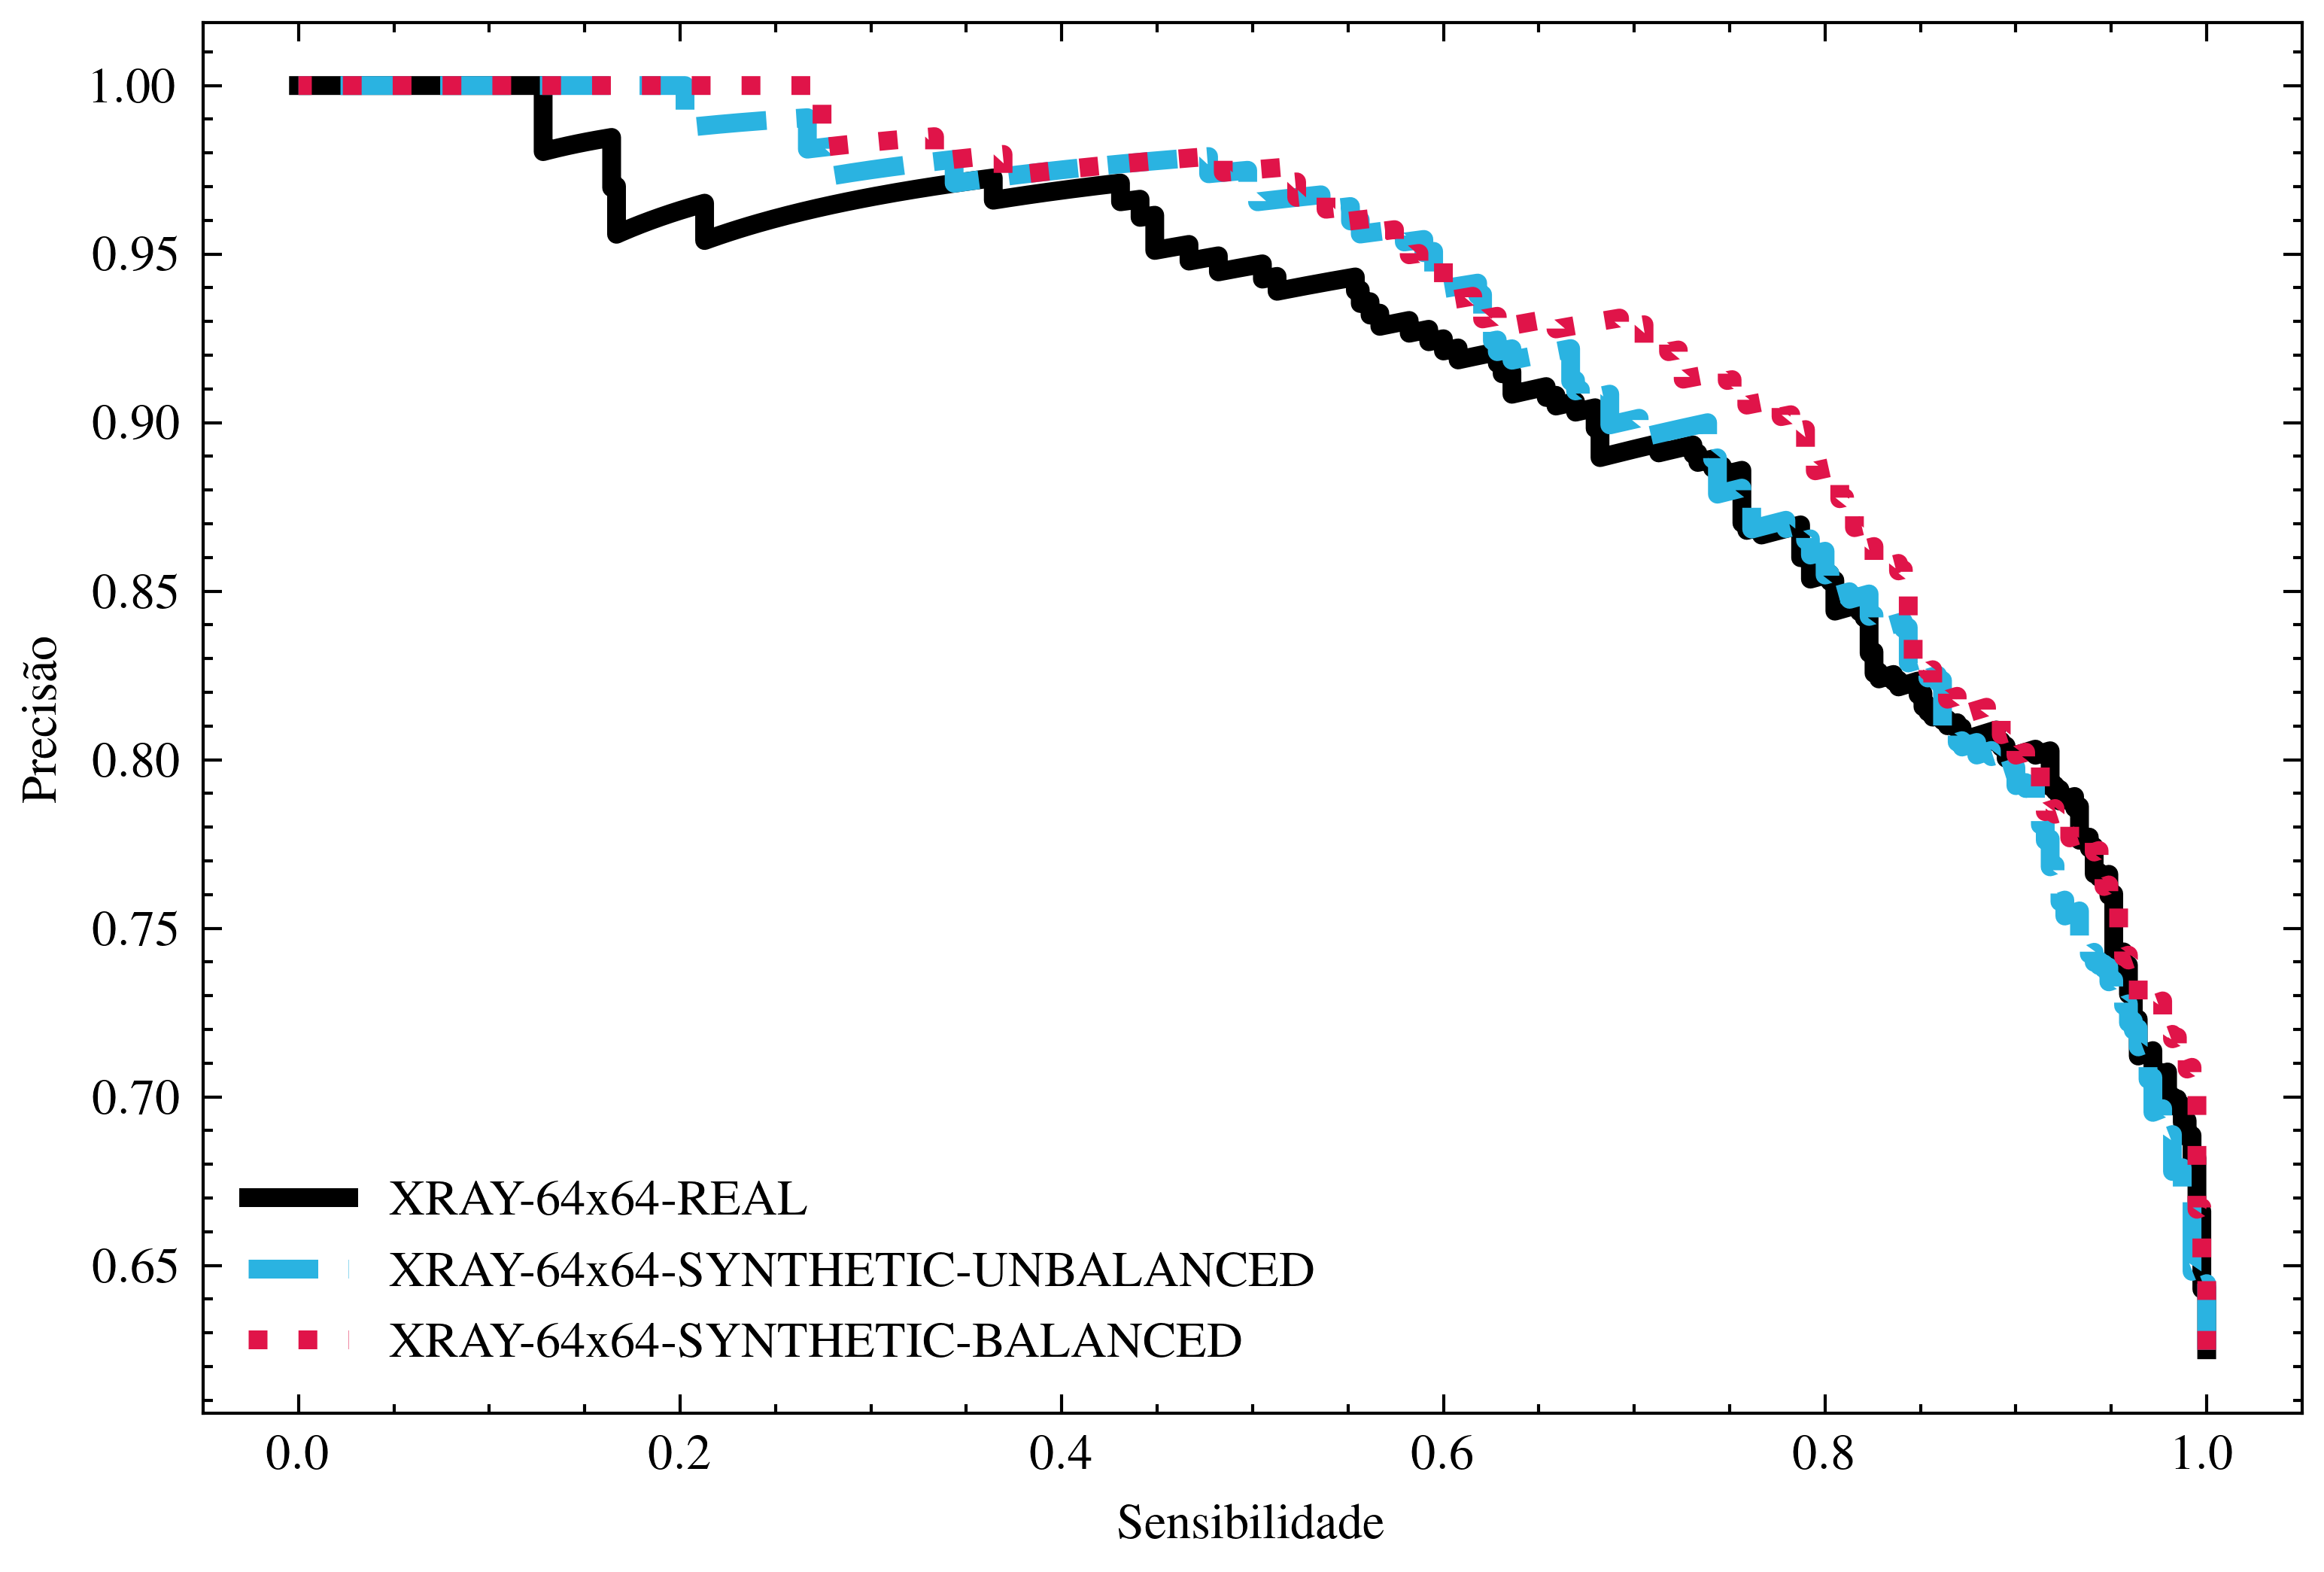

In [120]:
fig, ax = plt.subplots(figsize=(6, 4))

for idx, row in selected_exp_df.iterrows():
    p, r, t = row["Curva PR"]
    ax.plot(r, p, label=row["Experimento"], linewidth=3, color=exp_colors.get(row["Experimento"]))
    ax.set_xlabel("Sensibilidade")
    ax.set_ylabel("Precisão")

plt.legend()
plt.savefig("experimento-prcurve.eps")